In [5]:
import pickle
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [6]:
def read_file(filename):
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    df = pd.DataFrame(new_dict)
    return df

In [7]:
# Supervised Learning Evaluation
def supervised_learning_evaluate(pred, true_label):
    df = pd.DataFrame(metrics.classification_report(true_label, pred, output_dict=True)).transpose()
    print(df)
    print('accuracy_score:', metrics.accuracy_score(true_label, pred))

    return df

In [8]:
# Unsupervised Learning Evaluation
from scipy.stats import entropy
def unsupervised_learning_evaluate(pred, true_label):
    contingency_matrix = metrics.cluster.contingency_matrix(true_label, pred)
    value,counts = np.unique(pred, return_counts=True)
    print('Purity:', round(np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix),4))
    print('Entropy:', round(entropy(counts),4))
    return

In [9]:
def pred_transfer(pred):
    out = []
    for item in pred:
        if item == 0:
            out.append('negative')
        else:
            out.append('positive')
    return out


In [10]:
# feature selection
f = open('tfidf/tfidf_words.txt', 'rb')
words = f.readlines()
f.close()
feature_names = []
for w in words[1:]:
    feature_names.append(w[1:].strip().decode('utf-8'))

import sklearn.feature_selection as fs
def tfidf_list_to_df(data, feature_names):
    dic = {}
    for i in range(len(feature_names)):
        l = []
        for x in data:
            l.append(x[i])
        dic[feature_names[i]] = l
    return pd.DataFrame(dic)


def get_fw_names(sfs, feature_names):
    fw_list = []
    for i in range(len(sfs.get_support())):
        if sfs.get_support()[i] == True:
            fw_list.append(feature_names[i])
    return fw_list


def fs_KBest(X_train, y, X_test, score_func=fs.chi2, k=20):
    # SelectKBest
    sfs_KBest = fs.SelectKBest(score_func, k=k)
    fit = sfs_KBest.fit(X_train, y)
    new_train_X_KBest = sfs_KBest.fit_transform(X_train, y)
    new_test_X_KBest = fit.transform(X_test)
    return new_train_X_KBest, new_test_X_KBest


def fs_Fpr(X_train, y, X_test, score_func=fs.chi2, alpha=0.01):
    # SelectFpr
    sfs_Fpr = fs.SelectFpr(score_func, alpha=alpha)
    fit = sfs_Fpr.fit(X_train, y)
    new_train_X_Fpr = sfs_Fpr.fit_transform(X_train, y)
    new_test_X_Fpr = fit.transform(X_test)
    return new_train_X_Fpr, new_test_X_Fpr

In [ ]:
def auto_fs(X_train, y, X_test, y_test, classifier):
    max_score1 = 0
    for i in np.arange(0.01, 1, 0.01):
        new_train_X_Fpr, new_test_X_Fpr = fs_Fpr(X_train, y, X_test, alpha=i)
        pred = classifier(new_train_X_Fpr, y, new_test_X_Fpr)
        score = metrics.accuracy_score(pred, y_test)
        if score > max_score1:
            max_score1 = score
            max_alpha = i

    max_score2 = 0
    for k in range(10,X_train.shape[1]+1,10):
        new_train_X_KBest, new_test_X_KBest = fs_KBest(X_train, y, X_test, k=k)
        pred = classifier(new_train_X_KBest, y, new_test_X_KBest)
        score = metrics.accuracy_score(pred, y_test)
        if score > max_score2:
            max_score2 = score
            max_k = k
    return max_alpha, max_k

In [9]:
# Baseline
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
	output_values = train
	prediction = max(set(output_values), key=output_values.count)
	predicted = [prediction for i in range(len(test))]
	return predicted

In [10]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
def logistic(train_X, train_y, test_X):
    classifier = LogisticRegression()
    classifier.fit(train_X, train_y)
    return pred_transfer(classifier.predict(test_X))

In [11]:
# BernoulliNB & MultinomialNB
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
bnb = BernoulliNB()
mnb = MultinomialNB()
def bnb_train_predict(train_X, train_y, test_X):
    estimator = bnb
    estimator.fit(train_X, train_y)
    return pred_transfer(estimator.predict(test_X))
def mnb_train_predict(train_X, train_y, test_X):
    estimator = mnb
    estimator.fit(train_X, train_y)
    return pred_transfer(estimator.predict(test_X))

In [12]:
# light GBM
#!pip install lightgbm
import lightgbm as lgb
def light_gbm(train_X,train_y,test_X,test_y, eval_X):
    gbm = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05).fit(train_X,train_y,eval_metric='acc',eval_set=[(test_X,test_y)])
    return pred_transfer(gbm.predict(eval_X))

In [13]:
# Adaptive boost
from sklearn.ensemble import AdaBoostClassifier
def ada_boost(train_X, train_y,test_X):
    clf = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.1).fit(train_X,train_y)
    return pred_transfer(clf.predict(test_X))

In [14]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
def grad_boost(train_X, train_y,test_X):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=4, random_state=0).fit(train_X,train_y)
    return pred_transfer(clf.predict(test_X))

In [15]:
# random forest
from sklearn.ensemble import RandomForestClassifier
def random_forest(train_X, train_y,test_X):
    clf = RandomForestClassifier(max_depth=4, random_state=0).fit(train_X,train_y)
    return pred_transfer(clf.predict(test_X))

In [16]:
# SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
def support_vector_machine(train_X, train_y,test_X):
    clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='auto'))
    clf.fit(train_X, train_y)
    return pred_transfer(clf.predict(test_X))

In [17]:
# semi_supervised
# SelfTraining
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import ExtraTreeClassifier
def self_training(train_x, y, test_x):
    rng = np.random.RandomState(0)
    random_unlabeled_points = rng.rand(y.shape[0]) < 0.2
    y[random_unlabeled_points] = -1
    svc = ExtraTreeClassifier(random_state=0)
    self_training_model = SelfTrainingClassifier(svc)
    self_training_model.fit(train_x, y)
    return pred_transfer(self_training_model.predict(test_x))

In [18]:
# LabelSpreading
from sklearn.semi_supervised import LabelSpreading
def label_spreading(train_x, y, test_x):
    label_prop_model = LabelSpreading()
    rng = np.random.RandomState(42)
    random_unlabeled_points = rng.rand(len(y)) < 0.3
    labels = np.copy(y)
    labels[random_unlabeled_points] = -1
    label_prop_model.fit(train_x, y)
    return pred_transfer(label_prop_model.predict(test_x))

In [19]:
# Unsupervised
# Kmeans
from sklearn.cluster import KMeans
def k_means(train_x, test_x):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(train_x)
    return kmeans.predict(test_x)

In [20]:
# MeanShift
from sklearn.cluster import MeanShift
def mean_shift(train_x, test_x):
    clustering = MeanShift(bandwidth=2).fit(train_x)
    return clustering.predict(test_x)

In [69]:
# read raw data
raw_test = read_file('tweets-data/test.pkl')
raw_dev = read_file('tweets-data/dev.pkl')
raw_train = read_file('tweets-data/train.pkl')
raw_unlabelled = read_file('tweets-data/unlabeled.pkl')

In [70]:
# processing raw data
def remove_non_ascii(text):
    return ''.join([word for word in text if ord(word) <128])
raw_dev['text'] = [remove_non_ascii(review) for review in raw_dev['text']]

def add_dummy_label(data):
    dummy_labels = []
    for item in data['Sentiment']:
        if item == 'negative':
            dummy_labels.append(0)
        else:
            dummy_labels.append(1)
    data['label'] = pd.Series(dummy_labels)
    return
add_dummy_label(raw_dev)


In [71]:
def auto_fs_lightgbm(X_train, y, X_eval, y_eval,test_x, y_test):
    max_score1 = 0
    for i in np.arange(0.01, 1, 0.01):
        new_train_X_Fpr, new_test_X_Fpr = fs_Fpr(X_train, y, X_test, score_func=fs.chi2, alpha=i)
        pred = light_gbm(train_X,train_y,X_eval,y_eval, test_x)
        score = metrics.accuracy_score(pred, y_test)
        if score > max_score1:
            max_score1 = score
            max_alpha = i

    max_score2 = 0
    for k in range(5,X_train.shape[1],5):
        new_train_X_KBest, new_test_X_KBest = fs_KBest(X_train, y, X_test, score_func=fs.chi2, k=k)
        pred = light_gbm(train_X,train_y,X_eval,y_eval, test_x)
        score = metrics.accuracy_score(pred, y_test)
        if score > max_score2:
            max_score2 = score
            max_k = k
    return max_alpha, max_k

In [72]:
# ouput prediction
def test_data_output(pred_list, file_name_list):
    df_list = []
    for pred in pred_list:
        dic = {
               'category' : pred
        }
        df = pd.DataFrame(dic)
        df_list.append(df)
    for i in range(len(file_name_list)):
        df_list[i].to_csv(file_name_list[i])
    return

In [73]:
vect = CountVectorizer(stop_words='english', token_pattern=r'\w+', binary=True)
X = vect.fit_transform(raw_dev["text"])
X = X.astype(np.float64)
Y = pd.Series.to_numpy(raw_dev["Sentiment"])
Y = preprocessing.LabelEncoder().fit_transform(Y)
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=0)

In [26]:
# baseline
baseline_pred = zero_rule_algorithm_classification(train_y.tolist(), test_y.tolist())
supervised_learning_evaluate(pred_transfer(baseline_pred), pred_transfer(test_y))

              precision  recall  f1-score  support
negative       0.000000   0.000  0.000000  412.000
positive       0.485000   1.000  0.653199  388.000
accuracy       0.485000   0.485  0.485000    0.485
macro avg      0.242500   0.500  0.326599  800.000
weighted avg   0.235225   0.485  0.316801  800.000
accuracy_score: 0.485


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
negative,0.000000,0.000,0.000000,412.000
positive,0.485000,1.000,0.653199,388.000
accuracy,0.485000,0.485,0.485000,0.485
macro avg,0.242500,0.500,0.326599,800.000
weighted avg,0.235225,0.485,0.316801,800.000


In [27]:
# logistic regression
y_pred = logistic(train_X, train_y, test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative        0.67500  0.655340  0.665025   412.00
positive        0.64500  0.664948  0.654822   388.00
accuracy        0.66000  0.660000  0.660000     0.66
macro avg       0.66000  0.660144  0.659923   800.00
weighted avg    0.66045  0.660000  0.660077   800.00
accuracy_score: 0.66


,precision,recall,f1-score,support
negative,0.67500,0.655340,0.665025,412.00
positive,0.64500,0.664948,0.654822,388.00
accuracy,0.66000,0.660000,0.660000,0.66
macro avg,0.66000,0.660144,0.659923,800.00
weighted avg,0.66045,0.660000,0.660077,800.00


In [103]:
logistic_boost_max_alpha, logistic_boost_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), logistic)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, k=logistic_boost_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, alpha=logistic_boost_max_alpha)
print(logistic_boost_max_alpha, logistic_boost_max_k)
logistic_boost_kBest_pred = logistic(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(logistic_boost_kBest_pred, pred_transfer(test_y))
logistic_boost_Fpr_pred = logistic(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(logistic_boost_Fpr_pred, pred_transfer(test_y))

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

0.38 1300


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

              precision    recall  f1-score   support
negative       0.682927  0.679612  0.681265  412.0000
positive       0.661538  0.664948  0.663239  388.0000
accuracy       0.672500  0.672500  0.672500    0.6725
macro avg      0.672233  0.672280  0.672252  800.0000
weighted avg   0.672553  0.672500  0.672523  800.0000
accuracy_score: 0.6725
              precision    recall  f1-score    support
negative       0.680387  0.682039  0.681212  412.00000
positive       0.661499  0.659794  0.660645  388.00000
accuracy       0.671250  0.671250  0.671250    0.67125
macro avg      0.670943  0.670916  0.670929  800.00000
weighted avg   0.671226  0.671250  0.671237  800.00000
accuracy_score: 0.67125


,precision,recall,f1-score,support
negative,0.680387,0.682039,0.681212,412.00000
positive,0.661499,0.659794,0.660645,388.00000
accuracy,0.671250,0.671250,0.671250,0.67125
macro avg,0.670943,0.670916,0.670929,800.00000
weighted avg,0.671226,0.671250,0.671237,800.00000


In [40]:
# bnb
y_pred = bnb_train_predict(train_X, train_y, test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))
# mnb
y_pred = mnb_train_predict(train_X, train_y, test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.668950  0.711165  0.689412   412.00
positive       0.671271  0.626289  0.648000   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.670110  0.668727  0.668706   800.00
weighted avg   0.670075  0.670000  0.669327   800.00
accuracy_score: 0.67
              precision    recall  f1-score  support
negative       0.680488  0.677184  0.678832   412.00
positive       0.658974  0.662371  0.660668   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.669731  0.669778  0.669750   800.00
weighted avg   0.670054  0.670000  0.670023   800.00
accuracy_score: 0.67


,precision,recall,f1-score,support
negative,0.680488,0.677184,0.678832,412.00
positive,0.658974,0.662371,0.660668,388.00
accuracy,0.670000,0.670000,0.670000,0.67
macro avg,0.669731,0.669778,0.669750,800.00
weighted avg,0.670054,0.670000,0.670023,800.00


In [62]:
# bnb
bnb_max_alpha, bnb_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), bnb_train_predict)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, k=bnb_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, alpha=bnb_max_alpha)
print(bnb_max_alpha, bnb_max_k)
bnb_kBest_pred = bnb_train_predict(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(bnb_kBest_pred, pred_transfer(test_y))
bnb_Fpr_pred = bnb_train_predict(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(bnb_Fpr_pred, pred_transfer(test_y))

# mnb
mnb_max_alpha, mnb_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), mnb_train_predict)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, k=mnb_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, alpha=mnb_max_alpha)
print(mnb_max_alpha, mnb_max_k)
mnb_kBest_pred = mnb_train_predict(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(mnb_kBest_pred, pred_transfer(test_y))
mnb_Fpr_pred = mnb_train_predict(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(mnb_Fpr_pred, pred_transfer(test_y))

0.62 3980
              precision    recall  f1-score    support
negative       0.674944  0.725728  0.699415  412.00000
positive       0.683473  0.628866  0.655034  388.00000
accuracy       0.678750  0.678750  0.678750    0.67875
macro avg      0.679208  0.677297  0.677224  800.00000
weighted avg   0.679081  0.678750  0.677890  800.00000
accuracy_score: 0.67875
              precision    recall  f1-score    support
negative       0.674944  0.725728  0.699415  412.00000
positive       0.683473  0.628866  0.655034  388.00000
accuracy       0.678750  0.678750  0.678750    0.67875
macro avg      0.679208  0.677297  0.677224  800.00000
weighted avg   0.679081  0.678750  0.677890  800.00000
accuracy_score: 0.67875
0.99 4550
              precision    recall  f1-score  support
negative       0.685930  0.662621  0.674074   412.00
positive       0.654229  0.677835  0.665823   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.670079  0.670228  0.669948   800.00
weighte

,precision,recall,f1-score,support
negative,0.683544,0.655340,0.669145,412.00000
positive,0.649383,0.677835,0.663304,388.00000
accuracy,0.666250,0.666250,0.666250,0.66625
macro avg,0.666464,0.666587,0.666224,800.00000
weighted avg,0.666976,0.666250,0.666312,800.00000


In [75]:
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, raw_dev['label'], test_X, score_func=fs.chi2, alpha=bnb_max_alpha)
bnb_Fpr_pred = bnb_train_predict(train_X_Fpr, raw_dev['label'], test_X_Fpr)
test_data_output([bnb_Fpr_pred], ['bnb_Fpr_pred.csv'])

In [77]:
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, raw_dev['label'], test_X, score_func=fs.chi2, alpha=mnb_max_alpha)
mnb_Fpr_pred = mnb_train_predict(train_X_Fpr, raw_dev['label'], test_X_Fpr)
test_data_output([mnb_Fpr_pred], ['mnb_Fpr_pred.csv'])

In [9]:
# predict test data
raw_test['text'] = [remove_non_ascii(review) for review in raw_test['text']]
add_dummy_label(raw_test)
BernoulliNB_pred, MultinomialNB_pred, MultinomialNBWithTFIDF_pred= trainModel(raw_dev, raw_test)
file_name_list = ['BernoulliNB_pred.csv', 'MultinomialNB_pred.csv', 'MultinomialNBWithTFIDF_pred.csv']

test_data_output([BernoulliNB_pred, MultinomialNB_pred, MultinomialNBWithTFIDF_pred], file_name_list)

In [112]:
# light GBM
vect = CountVectorizer(stop_words='english', token_pattern=r'\w+', binary=True)
dfs = [raw_dev["text"], raw_test["text"]]
X = vect.fit_transform(pd.concat(dfs))
X = X.astype(np.float64)
Y = pd.Series.to_numpy(raw_dev["Sentiment"])
Y = preprocessing.LabelEncoder().fit_transform(Y)
raw_test_X = X[4000:]
train_X, test_X, train_y, test_y = train_test_split(X[:4000], Y, test_size=0.2, random_state=0)
y_pred = light_gbm(train_X,train_y, test_X,test_y, raw_test_X)
test_data_output([y_pred], ['LGBMClassifier_pred.csv'])

[1]	valid_0's binary_logloss: 0.688926
[2]	valid_0's binary_logloss: 0.684822
[3]	valid_0's binary_logloss: 0.681184
[4]	valid_0's binary_logloss: 0.67801
[5]	valid_0's binary_logloss: 0.675207
[6]	valid_0's binary_logloss: 0.672354
[7]	valid_0's binary_logloss: 0.67007
[8]	valid_0's binary_logloss: 0.667873
[9]	valid_0's binary_logloss: 0.666114
[10]	valid_0's binary_logloss: 0.664382
[11]	valid_0's binary_logloss: 0.662578
[12]	valid_0's binary_logloss: 0.661165
[13]	valid_0's binary_logloss: 0.660024
[14]	valid_0's binary_logloss: 0.658681
[15]	valid_0's binary_logloss: 0.657292
[16]	valid_0's binary_logloss: 0.656036
[17]	valid_0's binary_logloss: 0.655239
[18]	valid_0's binary_logloss: 0.654396
[19]	valid_0's binary_logloss: 0.653541
[20]	valid_0's binary_logloss: 0.652713
[21]	valid_0's binary_logloss: 0.652043
[22]	valid_0's binary_logloss: 0.651377
[23]	valid_0's binary_logloss: 0.650602
[24]	valid_0's binary_logloss: 0.649939
[25]	valid_0's binary_logloss: 0.649196
[26]	valid_

In [ ]:
vect = CountVectorizer(stop_words='english', token_pattern=r'\w+', binary=True)
X = vect.fit_transform(raw_dev["text"])
X = X.astype(np.float64)
Y = pd.Series.to_numpy(raw_dev["Sentiment"])
Y = preprocessing.LabelEncoder().fit_transform(Y)
x, eval_X, y, eval_y = train_test_split(X, Y, test_size=0.2, random_state=1)
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=0)
y_pred = light_gbm(train_X,train_y, test_X,test_y, eval_X)
supervised_learning_evaluate(y_pred, pred_transfer(eval_y))

In [ ]:
light_gbm_max_alpha, light_gbm_max_k = auto_fs_lightgbm(train_X, train_y, test_X, pred_transfer(test_y), bnb_train_predict)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=bnb_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=bnb_max_alpha)
print(bnb_max_alpha, bnb_max_k)
bnb_kBest_pred = bnb_train_predict(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(bnb_kBest_pred, pred_transfer(test_y))
bnb_Fpr_pred = bnb_train_predict(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(bnb_Fpr_pred, pred_transfer(test_y))


In [73]:
# adaptive boost
vect = CountVectorizer(stop_words='english', token_pattern=r'\w+', binary=True)
dfs = [raw_dev["text"], raw_test["text"]]
X = vect.fit_transform(pd.concat(dfs))
X = X.astype(np.float64)
Y = pd.Series.to_numpy(raw_dev["Sentiment"])
Y = preprocessing.LabelEncoder().fit_transform(Y)
raw_test_X = X[4000:]
y_pred = ada_boost(X[:4000],Y,raw_test_X)
test_data_output([y_pred], ['AdaBoost_pred.csv'])

In [56]:
vect = CountVectorizer(stop_words='english', token_pattern=r'\w+', binary=True)
X = vect.fit_transform(raw_dev["text"])
X = X.astype(np.float64)
Y = pd.Series.to_numpy(raw_dev["Sentiment"])
Y = preprocessing.LabelEncoder().fit_transform(Y)
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=0)
y_pred = ada_boost(train_X, train_y,test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score   support
negative       0.626506  0.757282  0.685714  412.0000
positive       0.668874  0.520619  0.585507  388.0000
accuracy       0.642500  0.642500  0.642500    0.6425
macro avg      0.647690  0.638950  0.635611  800.0000
weighted avg   0.647055  0.642500  0.637114  800.0000
accuracy_score: 0.6425


,precision,recall,f1-score,support
negative,0.626506,0.757282,0.685714,412.0000
positive,0.668874,0.520619,0.585507,388.0000
accuracy,0.642500,0.642500,0.642500,0.6425
macro avg,0.647690,0.638950,0.635611,800.0000
weighted avg,0.647055,0.642500,0.637114,800.0000


In [63]:
ada_boost_max_alpha, ada_boost_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), ada_boost)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=ada_boost_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=ada_boost_max_alpha)
print(ada_boost_max_alpha, ada_boost_max_k)
ada_boost_kBest_pred = ada_boost(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(ada_boost_kBest_pred, pred_transfer(test_y))
ada_boost_Fpr_pred = ada_boost(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(ada_boost_Fpr_pred, pred_transfer(test_y))

0.02 30
              precision    recall  f1-score    support
negative       0.625743  0.766990  0.689204  412.00000
positive       0.674576  0.512887  0.582723  388.00000
accuracy       0.643750  0.643750  0.643750    0.64375
macro avg      0.650159  0.639938  0.635964  800.00000
weighted avg   0.649427  0.643750  0.637561  800.00000
accuracy_score: 0.64375
              precision    recall  f1-score   support
negative       0.626506  0.757282  0.685714  412.0000
positive       0.668874  0.520619  0.585507  388.0000
accuracy       0.642500  0.642500  0.642500    0.6425
macro avg      0.647690  0.638950  0.635611  800.0000
weighted avg   0.647055  0.642500  0.637114  800.0000
accuracy_score: 0.6425


,precision,recall,f1-score,support
negative,0.626506,0.757282,0.685714,412.0000
positive,0.668874,0.520619,0.585507,388.0000
accuracy,0.642500,0.642500,0.642500,0.6425
macro avg,0.647690,0.638950,0.635611,800.0000
weighted avg,0.647055,0.642500,0.637114,800.0000


In [21]:
# Gradient boosting
grad_boost(train_X, train_y,test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score   support
negative       0.633745  0.747573  0.685969  412.0000
positive       0.668790  0.541237  0.598291  388.0000
accuracy       0.647500  0.647500  0.647500    0.6475
macro avg      0.651267  0.644405  0.642130  800.0000
weighted avg   0.650742  0.647500  0.643445  800.0000
accuracy_score: 0.6475


,precision,recall,f1-score,support
negative,0.633745,0.747573,0.685969,412.0000
positive,0.668790,0.541237,0.598291,388.0000
accuracy,0.647500,0.647500,0.647500,0.6475
macro avg,0.651267,0.644405,0.642130,800.0000
weighted avg,0.650742,0.647500,0.643445,800.0000


In [58]:
grad_boost_max_alpha, grad_boost_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), grad_boost)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=grad_boost_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=grad_boost_max_alpha)
print(grad_boost_max_alpha, grad_boost_max_k)
grad_boost_kBest_pred = grad_boost(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(grad_boost_kBest_pred, pred_transfer(test_y))
grad_boost_Fpr_pred = grad_boost(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(grad_boost_Fpr_pred, pred_transfer(test_y))

0.88 5015
              precision    recall  f1-score   support
negative       0.652720  0.757282  0.701124  412.0000
positive       0.689441  0.572165  0.625352  388.0000
accuracy       0.667500  0.667500  0.667500    0.6675
macro avg      0.671080  0.664723  0.663238  800.0000
weighted avg   0.670530  0.667500  0.664374  800.0000
accuracy_score: 0.6675
              precision    recall  f1-score    support
negative       0.649049  0.745146  0.693785  412.00000
positive       0.678899  0.572165  0.620979  388.00000
accuracy       0.661250  0.661250  0.661250    0.66125
macro avg      0.663974  0.658655  0.657382  800.00000
weighted avg   0.663526  0.661250  0.658474  800.00000
accuracy_score: 0.66125


,precision,recall,f1-score,support
negative,0.649049,0.745146,0.693785,412.00000
positive,0.678899,0.572165,0.620979,388.00000
accuracy,0.661250,0.661250,0.661250,0.66125
macro avg,0.663974,0.658655,0.657382,800.00000
weighted avg,0.663526,0.661250,0.658474,800.00000


In [29]:
# Random forest
random_forest(X[:4000], Y,raw_test_X)
test_data_output([y_pred], ['RandomForest_pred.csv'])

In [59]:
y_pred = random_forest(train_X, train_y,test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.658711  0.669903  0.664260  412.00000
positive       0.643045  0.631443  0.637191  388.00000
accuracy       0.651250  0.651250  0.651250    0.65125
macro avg      0.650878  0.650673  0.650726  800.00000
weighted avg   0.651113  0.651250  0.651132  800.00000
accuracy_score: 0.65125


,precision,recall,f1-score,support
negative,0.658711,0.669903,0.664260,412.00000
positive,0.643045,0.631443,0.637191,388.00000
accuracy,0.651250,0.651250,0.651250,0.65125
macro avg,0.650878,0.650673,0.650726,800.00000
weighted avg,0.651113,0.651250,0.651132,800.00000


In [68]:
random_forest_max_alpha, random_forest_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), random_forest)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=random_forest_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=random_forest_max_alpha)
print(random_forest_max_alpha, random_forest_max_k)
random_forest_kBest_pred = random_forest(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(random_forest_kBest_pred, pred_transfer(test_y))
random_forest_Fpr_pred = random_forest(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(random_forest_Fpr_pred, pred_transfer(test_y))

0.4 1270
              precision    recall  f1-score   support
negative       0.667431  0.706311  0.686321  412.0000
positive       0.667582  0.626289  0.646277  388.0000
accuracy       0.667500  0.667500  0.667500    0.6675
macro avg      0.667507  0.666300  0.666299  800.0000
weighted avg   0.667505  0.667500  0.666899  800.0000
accuracy_score: 0.6675
              precision    recall  f1-score    support
negative       0.663573  0.694175  0.678529  412.00000
positive       0.658537  0.626289  0.642008  388.00000
accuracy       0.661250  0.661250  0.661250    0.66125
macro avg      0.661055  0.660232  0.660268  800.00000
weighted avg   0.661130  0.661250  0.660816  800.00000
accuracy_score: 0.66125


,precision,recall,f1-score,support
negative,0.663573,0.694175,0.678529,412.00000
positive,0.658537,0.626289,0.642008,388.00000
accuracy,0.661250,0.661250,0.661250,0.66125
macro avg,0.661055,0.660232,0.660268,800.00000
weighted avg,0.661130,0.661250,0.660816,800.00000


In [ ]:
# SVM
support_vector_machine(X[:4000], Y,raw_test_X)
test_data_output([y_pred], ['SVM_pred.csv'])

In [69]:
y_pred = support_vector_machine(train_X, train_y,test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

ValueError: Cannot center sparse matrices: pass `with_mean=False` instead. See docstring for motivation and alternatives.

In [ ]:
svm_max_alpha, svm_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), support_vector_machine)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=svm_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=svm_max_alpha)
print(svm_max_alpha, svm_max_k)
svm_kBest_pred = support_vector_machine(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(svm_kBest_pred, pred_transfer(test_y))
svm_Fpr_pred = support_vector_machine(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(svm_Fpr_pred, pred_transfer(test_y))

In [98]:
# self_training
self_training_pred = self_training(train_X, train_y,test_X)
supervised_learning_evaluate(self_training_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.581509  0.580097  0.580802  412.00000
positive       0.555270  0.556701  0.555985  388.00000
accuracy       0.568750  0.568750  0.568750    0.56875
macro avg      0.568389  0.568399  0.568393  800.00000
weighted avg   0.568783  0.568750  0.568766  800.00000
accuracy_score: 0.56875


,precision,recall,f1-score,support
negative,0.581509,0.580097,0.580802,412.00000
positive,0.555270,0.556701,0.555985,388.00000
accuracy,0.568750,0.568750,0.568750,0.56875
macro avg,0.568389,0.568399,0.568393,800.00000
weighted avg,0.568783,0.568750,0.568766,800.00000


In [70]:
self_training_max_alpha, self_training_max_k = auto_fs(train_X, train_y, test_X, pred_transfer(test_y), self_training)
train_X_KBest, test_X_KBest = fs_KBest(train_X, train_y, test_X, score_func=fs.chi2, k=self_training_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(train_X, train_y, test_X, score_func=fs.chi2, alpha=self_training_max_alpha)
print(self_training_max_alpha, self_training_max_k)
self_training_kBest_pred = self_training(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(self_training_kBest_pred, pred_transfer(test_y))
self_training_Fpr_pred = self_training(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(self_training_Fpr_pred, pred_transfer(test_y))

0.28 1220
              precision    recall  f1-score    support
negative       0.649203  0.691748  0.669800  412.00000
positive       0.648199  0.603093  0.624833  388.00000
accuracy       0.648750  0.648750  0.648750    0.64875
macro avg      0.648701  0.647420  0.647317  800.00000
weighted avg   0.648716  0.648750  0.647991  800.00000
accuracy_score: 0.64875
              precision    recall  f1-score   support
negative       0.641892  0.691748  0.665888  412.0000
positive       0.643258  0.590206  0.615591  388.0000
accuracy       0.642500  0.642500  0.642500    0.6425
macro avg      0.642575  0.640977  0.640740  800.0000
weighted avg   0.642555  0.642500  0.641494  800.0000
accuracy_score: 0.6425


,precision,recall,f1-score,support
negative,0.641892,0.691748,0.665888,412.0000
positive,0.643258,0.590206,0.615591,388.0000
accuracy,0.642500,0.642500,0.642500,0.6425
macro avg,0.642575,0.640977,0.640740,800.0000
weighted avg,0.642555,0.642500,0.641494,800.0000


In [67]:
# label spreading
pred = label_spreading(train_X.toarray(), train_y,test_X.toarray())
supervised_learning_evaluate(pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.542553  0.495146  0.517766  412.000
positive       0.509434  0.556701  0.532020  388.000
accuracy       0.525000  0.525000  0.525000    0.525
macro avg      0.525994  0.525923  0.524893  800.000
weighted avg   0.526490  0.525000  0.524679  800.000
accuracy_score: 0.525


,precision,recall,f1-score,support
negative,0.542553,0.495146,0.517766,412.000
positive,0.509434,0.556701,0.532020,388.000
accuracy,0.525000,0.525000,0.525000,0.525
macro avg,0.525994,0.525923,0.524893,800.000
weighted avg,0.526490,0.525000,0.524679,800.000


In [74]:
def inverse_pred_transfer(pred):
    out = []
    for item in pred:
        if item == 1:
            out.append('negative')
        else:
            out.append('positive')
    return out

In [29]:
# Kmeans
Kmeans_pred = k_means(train_X, test_X)
unsupervised_learning_evaluate(Kmeans_pred, test_y)

Purity: 0.6225
Entropy: 0.623


In [11]:
# read tfidf data
tfidf_test = read_file('tfidf/test_tfidf.pkl')
tfidf_dev = read_file('tfidf/dev_tfidf.pkl')
tfidf_train = read_file('tfidf/train_tfidf.pkl')
tfidf_unlabelled = read_file('tfidf/unlabeled_tfidf.pkl')

In [12]:
# processing tfidf data
dummy_labels = []
for item in tfidf_dev['Sentiment']:
    if item == 'negative':
        dummy_labels.append(0)
    else:
        dummy_labels.append(1)
tfidf_dev['label'] = pd.Series(dummy_labels)

In [101]:
# Check the training and test set feature distribution consistency
import scipy.stats
import matplotlib.pyplot as plt
def JS_divergence(p,q):
    M=(p+q)/2
    return 0.5*scipy.stats.entropy(p,M)+0.5*scipy.stats.entropy(q, M)

D:\anaconda3\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
D:\anaconda3\lib\site-packages\scipy\stats\_entropy.py:78: RuntimeWarning: invalid value encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)


2718


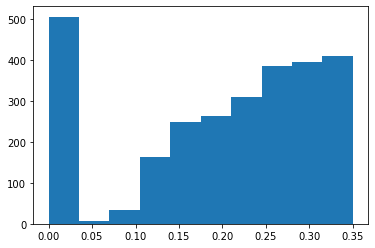

In [107]:
JS = []
selected_instances = []
for i in range(len(tfidf_dev['TFIDF'])):
    instance = tfidf_dev.iloc[i,0]
    rest = tfidf_dev.iloc[i,:]
    min_js = 1
    for item in tfidf_test['TFIDF']:
        js = JS_divergence(item, instance)
        if js < min_js:
            min_js = js
    if min_js <= 0.35:
        JS.append(min_js)
        selected_instances.append(rest)
selected_data = pd.DataFrame(selected_instances)

plt.hist(JS)
print(len(JS))

In [111]:
f = open("selected_tfidf_train_set.pkl",'wb')
pickle.dump(selected_data, f)
f.close()

In [13]:
train_set, test_set = train_test_split(tfidf_dev, test_size=0.2, random_state=0)
tfidf_train_X, train_y = train_set['TFIDF'], train_set['label']
tfidf_test_X, test_y = test_set['TFIDF'], test_set['label']

tfidf_train_X = tfidf_list_to_df(tfidf_train_X, feature_names)
tfidf_test_X = tfidf_list_to_df(tfidf_test_X, feature_names)


In [14]:
mean = tfidf_train_X.describe().iloc[1,:].tolist()
min = tfidf_train_X.describe().iloc[3,:].tolist()
max = tfidf_train_X.describe().iloc[7,:].tolist()

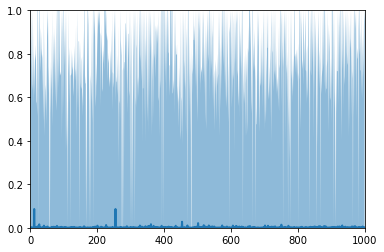

In [20]:
x = range(1,1001)
fig, ax = plt.subplots()
ax.fill_between(x, min, max, alpha=.5, linewidth=0)
ax.plot(x, mean, linewidth=2)
ax.set(xlim=(0, 1001),
       ylim=(0, 1), yticks=np.arange(0, 1.2, 0.2),
       )
plt.show()
fig.savefig("tfidf.jpg",dpi=300)

In [19]:
y_pred = support_vector_machine(tfidf_train_X, train_y,tfidf_test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.629630  0.618932  0.624235  412.00000
positive       0.602532  0.613402  0.607918  388.00000
accuracy       0.616250  0.616250  0.616250    0.61625
macro avg      0.616081  0.616167  0.616077  800.00000
weighted avg   0.616487  0.616250  0.616321  800.00000
accuracy_score: 0.61625


,precision,recall,f1-score,support
negative,0.629630,0.618932,0.624235,412.00000
positive,0.602532,0.613402,0.607918,388.00000
accuracy,0.616250,0.616250,0.616250,0.61625
macro avg,0.616081,0.616167,0.616077,800.00000
weighted avg,0.616487,0.616250,0.616321,800.00000


In [30]:
# baseline
baseline_pred = zero_rule_algorithm_classification(train_y.tolist(), test_y.tolist())
supervised_learning_evaluate(pred_transfer(baseline_pred), pred_transfer(test_y))

              precision  recall  f1-score  support
negative       0.000000   0.000  0.000000  412.000
positive       0.485000   1.000  0.653199  388.000
accuracy       0.485000   0.485  0.485000    0.485
macro avg      0.242500   0.500  0.326599  800.000
weighted avg   0.235225   0.485  0.316801  800.000
accuracy_score: 0.485


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
negative,0.000000,0.000,0.000000,412.000
positive,0.485000,1.000,0.653199,388.000
accuracy,0.485000,0.485,0.485000,0.485
macro avg,0.242500,0.500,0.326599,800.000
weighted avg,0.235225,0.485,0.316801,800.000


In [34]:
# Kmeans
Kmeans_pred = k_means(tfidf_train_X, tfidf_test_X)
unsupervised_learning_evaluate(pred_transfer(Kmeans_pred), pred_transfer(test_y))

Purity: 0.60625
Entropy: 0.5637


In [47]:
# Logistic regression
Logistic_pred = logistic(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(Logistic_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.678744  0.682039  0.680387   412.00
positive       0.660622  0.657216  0.658915   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.669683  0.669628  0.669651   800.00
weighted avg   0.669955  0.670000  0.669973   800.00
accuracy_score: 0.67


,precision,recall,f1-score,support
negative,0.678744,0.682039,0.680387,412.00
positive,0.660622,0.657216,0.658915,388.00
accuracy,0.670000,0.670000,0.670000,0.67
macro avg,0.669683,0.669628,0.669651,800.00
weighted avg,0.669955,0.670000,0.669973,800.00


In [81]:
Logistic_max_alpha, Logistic_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), logistic)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=Logistic_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=Logistic_max_alpha)
print(Logistic_max_alpha, Logistic_max_k)
Logistic_kBest_pred = logistic(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(Logistic_kBest_pred, pred_transfer(test_y))
Logistic_Fpr_pred = logistic(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(Logistic_Fpr_pred, pred_transfer(test_y))

0.28 890
              precision    recall  f1-score    support
negative       0.678657  0.686893  0.682750  412.00000
positive       0.663185  0.654639  0.658885  388.00000
accuracy       0.671250  0.671250  0.671250    0.67125
macro avg      0.670921  0.670766  0.670817  800.00000
weighted avg   0.671153  0.671250  0.671175  800.00000
accuracy_score: 0.67125
              precision    recall  f1-score    support
negative       0.661605  0.740291  0.698740  412.00000
positive       0.684366  0.597938  0.638239  388.00000
accuracy       0.671250  0.671250  0.671250    0.67125
macro avg      0.672985  0.669115  0.668490  800.00000
weighted avg   0.672644  0.671250  0.669397  800.00000
accuracy_score: 0.67125


,precision,recall,f1-score,support
negative,0.661605,0.740291,0.698740,412.00000
positive,0.684366,0.597938,0.638239,388.00000
accuracy,0.671250,0.671250,0.671250,0.67125
macro avg,0.672985,0.669115,0.668490,800.00000
weighted avg,0.672644,0.671250,0.669397,800.00000


In [117]:
# bnb
bnb_pred = bnb_train_predict(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(bnb_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.671429  0.684466  0.677885  412.000
positive       0.657895  0.644330  0.651042  388.000
accuracy       0.665000  0.665000  0.665000    0.665
macro avg      0.664662  0.664398  0.664463  800.000
weighted avg   0.664865  0.665000  0.664866  800.000
accuracy_score: 0.665


,precision,recall,f1-score,support
negative,0.671429,0.684466,0.677885,412.000
positive,0.657895,0.644330,0.651042,388.000
accuracy,0.665000,0.665000,0.665000,0.665
macro avg,0.664662,0.664398,0.664463,800.000
weighted avg,0.664865,0.665000,0.664866,800.000


In [82]:
bnb_max_alpha, bnb_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), bnb_train_predict)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=bnb_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=bnb_max_alpha)
print(bnb_max_alpha, bnb_max_k)
bnb_kBest_pred = bnb_train_predict(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(bnb_kBest_pred, pred_transfer(test_y))
bnb_Fpr_pred = bnb_train_predict(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(bnb_Fpr_pred, pred_transfer(test_y))

0.5700000000000001 560
              precision    recall  f1-score  support
negative       0.672093  0.701456  0.686461   412.00
positive       0.667568  0.636598  0.651715   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.669830  0.669027  0.669088   800.00
weighted avg   0.669898  0.670000  0.669609   800.00
accuracy_score: 0.67
              precision    recall  f1-score  support
negative       0.670507  0.706311  0.687943   412.00
positive       0.669399  0.631443  0.649867   388.00
accuracy       0.670000  0.670000  0.670000     0.67
macro avg      0.669953  0.668877  0.668905   800.00
weighted avg   0.669970  0.670000  0.669476   800.00
accuracy_score: 0.67


,precision,recall,f1-score,support
negative,0.670507,0.706311,0.687943,412.00
positive,0.669399,0.631443,0.649867,388.00
accuracy,0.670000,0.670000,0.670000,0.67
macro avg,0.669953,0.668877,0.668905,800.00
weighted avg,0.669970,0.670000,0.669476,800.00


In [32]:
# mnb
mnb_pred = mnb_train_predict(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(mnb_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.671429  0.684466  0.677885  412.000
positive       0.657895  0.644330  0.651042  388.000
accuracy       0.665000  0.665000  0.665000    0.665
macro avg      0.664662  0.664398  0.664463  800.000
weighted avg   0.664865  0.665000  0.664866  800.000
accuracy_score: 0.665


,precision,recall,f1-score,support
negative,0.671429,0.684466,0.677885,412.000
positive,0.657895,0.644330,0.651042,388.000
accuracy,0.665000,0.665000,0.665000,0.665
macro avg,0.664662,0.664398,0.664463,800.000
weighted avg,0.664865,0.665000,0.664866,800.000


In [83]:
mnb_max_alpha, mnb_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), mnb_train_predict)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=mnb_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=mnb_max_alpha)
print(mnb_max_alpha, mnb_max_k)
mnb_kBest_pred = mnb_train_predict(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(mnb_kBest_pred, pred_transfer(test_y))
mnb_Fpr_pred = mnb_train_predict(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(mnb_Fpr_pred, pred_transfer(test_y))

0.92 880
              precision    recall  f1-score  support
negative       0.690722  0.650485      0.67   412.00
positive       0.650485  0.690722      0.67   388.00
accuracy       0.670000  0.670000      0.67     0.67
macro avg      0.670604  0.670604      0.67   800.00
weighted avg   0.671207  0.670000      0.67   800.00
accuracy_score: 0.67
              precision    recall  f1-score  support
negative       0.690722  0.650485      0.67   412.00
positive       0.650485  0.690722      0.67   388.00
accuracy       0.670000  0.670000      0.67     0.67
macro avg      0.670604  0.670604      0.67   800.00
weighted avg   0.671207  0.670000      0.67   800.00
accuracy_score: 0.67


,precision,recall,f1-score,support
negative,0.690722,0.650485,0.67,412.00
positive,0.650485,0.690722,0.67,388.00
accuracy,0.670000,0.670000,0.67,0.67
macro avg,0.670604,0.670604,0.67,800.00
weighted avg,0.671207,0.670000,0.67,800.00


In [48]:
# lightgbm
eval_train_set, eval_test_set = train_test_split(tfidf_dev, test_size=0.2, random_state=1)
eval_tfidf_train_X, eval_train_y = train_set['TFIDF'], train_set['label']
eval_tfidf_test_X, eval_test_y = test_set['TFIDF'], test_set['label']

eval_tfidf_train_X = tfidf_list_to_df(eval_tfidf_train_X, feature_names)
eval_tfidf_test_X = tfidf_list_to_df(eval_tfidf_test_X, feature_names)
lightgbm_pred = light_gbm(tfidf_train_X,train_y,eval_tfidf_test_X,eval_test_y,tfidf_test_X)
supervised_learning_evaluate(lightgbm_pred, pred_transfer(test_y))

[1]	valid_0's binary_logloss: 0.68919
[2]	valid_0's binary_logloss: 0.685223
[3]	valid_0's binary_logloss: 0.681866
[4]	valid_0's binary_logloss: 0.678766
[5]	valid_0's binary_logloss: 0.675674
[6]	valid_0's binary_logloss: 0.673163
[7]	valid_0's binary_logloss: 0.670897
[8]	valid_0's binary_logloss: 0.668961
[9]	valid_0's binary_logloss: 0.667024
[10]	valid_0's binary_logloss: 0.665228
[11]	valid_0's binary_logloss: 0.663656
[12]	valid_0's binary_logloss: 0.662037
[13]	valid_0's binary_logloss: 0.660748
[14]	valid_0's binary_logloss: 0.659605
[15]	valid_0's binary_logloss: 0.658863
[16]	valid_0's binary_logloss: 0.657858
[17]	valid_0's binary_logloss: 0.656911
[18]	valid_0's binary_logloss: 0.655731
[19]	valid_0's binary_logloss: 0.655439
[20]	valid_0's binary_logloss: 0.654422
[21]	valid_0's binary_logloss: 0.654333
[22]	valid_0's binary_logloss: 0.653957
[23]	valid_0's binary_logloss: 0.653431
[24]	valid_0's binary_logloss: 0.652983
[25]	valid_0's binary_logloss: 0.652716
[26]	valid

,precision,recall,f1-score,support
negative,0.615566,0.633495,0.624402,412.0000
positive,0.598404,0.579897,0.589005,388.0000
accuracy,0.607500,0.607500,0.607500,0.6075
macro avg,0.606985,0.606696,0.606704,800.0000
weighted avg,0.607243,0.607500,0.607235,800.0000


In [124]:
# Ada boost
ada_pred = ada_boost(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(ada_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.627255  0.759709  0.687157  412.00000
positive       0.671096  0.520619  0.586357  388.00000
accuracy       0.643750  0.643750  0.643750    0.64375
macro avg      0.649175  0.640164  0.636757  800.00000
weighted avg   0.648518  0.643750  0.638269  800.00000
accuracy_score: 0.64375


,precision,recall,f1-score,support
negative,0.627255,0.759709,0.687157,412.00000
positive,0.671096,0.520619,0.586357,388.00000
accuracy,0.643750,0.643750,0.643750,0.64375
macro avg,0.649175,0.640164,0.636757,800.00000
weighted avg,0.648518,0.643750,0.638269,800.00000


In [84]:
ada_max_alpha, ada_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), ada_boost)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=ada_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=ada_max_alpha)
print(ada_max_alpha, ada_max_k)
ada_kBest_pred = ada_boost(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(ada_kBest_pred, pred_transfer(test_y))
ada_Fpr_pred = ada_boost(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(ada_Fpr_pred, pred_transfer(test_y))

0.09999999999999999 80
              precision    recall  f1-score    support
negative       0.626243  0.764563  0.688525  412.00000
positive       0.673401  0.515464  0.583942  388.00000
accuracy       0.643750  0.643750  0.643750    0.64375
macro avg      0.649822  0.640014  0.636233  800.00000
weighted avg   0.649114  0.643750  0.637802  800.00000
accuracy_score: 0.64375
              precision    recall  f1-score    support
negative       0.626243  0.764563  0.688525  412.00000
positive       0.673401  0.515464  0.583942  388.00000
accuracy       0.643750  0.643750  0.643750    0.64375
macro avg      0.649822  0.640014  0.636233  800.00000
weighted avg   0.649114  0.643750  0.637802  800.00000
accuracy_score: 0.64375


,precision,recall,f1-score,support
negative,0.626243,0.764563,0.688525,412.00000
positive,0.673401,0.515464,0.583942,388.00000
accuracy,0.643750,0.643750,0.643750,0.64375
macro avg,0.649822,0.640014,0.636233,800.00000
weighted avg,0.649114,0.643750,0.637802,800.00000


In [126]:
# gradient boost
grad_pred = grad_boost(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(grad_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.615711  0.703883  0.656852  412.00000
positive       0.629179  0.533505  0.577406  388.00000
accuracy       0.621250  0.621250  0.621250    0.62125
macro avg      0.622445  0.618694  0.617129  800.00000
weighted avg   0.622243  0.621250  0.618320  800.00000
accuracy_score: 0.62125


,precision,recall,f1-score,support
negative,0.615711,0.703883,0.656852,412.00000
positive,0.629179,0.533505,0.577406,388.00000
accuracy,0.621250,0.621250,0.621250,0.62125
macro avg,0.622445,0.618694,0.617129,800.00000
weighted avg,0.622243,0.621250,0.618320,800.00000


In [85]:
grad_max_alpha, grad_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), grad_boost)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=grad_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=grad_max_alpha)
print(grad_max_alpha, grad_max_k)
grad_kBest_pred = grad_boost(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(grad_kBest_pred, pred_transfer(test_y))
grad_Fpr_pred = grad_boost(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(grad_Fpr_pred, pred_transfer(test_y))

0.77 920
              precision    recall  f1-score    support
negative       0.645161  0.728155  0.684151  412.00000
positive       0.665672  0.574742  0.616874  388.00000
accuracy       0.653750  0.653750  0.653750    0.65375
macro avg      0.655416  0.651449  0.650512  800.00000
weighted avg   0.655109  0.653750  0.651521  800.00000
accuracy_score: 0.65375
              precision    recall  f1-score  support
negative       0.654867  0.718447  0.685185   412.00
positive       0.666667  0.597938  0.630435   388.00
accuracy       0.660000  0.660000  0.660000     0.66
macro avg      0.660767  0.658192  0.657810   800.00
weighted avg   0.660590  0.660000  0.658631   800.00
accuracy_score: 0.66


,precision,recall,f1-score,support
negative,0.654867,0.718447,0.685185,412.00
positive,0.666667,0.597938,0.630435,388.00
accuracy,0.660000,0.660000,0.660000,0.66
macro avg,0.660767,0.658192,0.657810,800.00
weighted avg,0.660590,0.660000,0.658631,800.00


In [41]:
# random forest
random_forest_pred = random_forest(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(random_forest_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.646055  0.735437  0.687855  412.00000
positive       0.670695  0.572165  0.617524  388.00000
accuracy       0.656250  0.656250  0.656250    0.65625
macro avg      0.658375  0.653801  0.652690  800.00000
weighted avg   0.658006  0.656250  0.653744  800.00000
accuracy_score: 0.65625


,precision,recall,f1-score,support
negative,0.646055,0.735437,0.687855,412.00000
positive,0.670695,0.572165,0.617524,388.00000
accuracy,0.656250,0.656250,0.656250,0.65625
macro avg,0.658375,0.653801,0.652690,800.00000
weighted avg,0.658006,0.656250,0.653744,800.00000


In [86]:
rf_max_alpha, rf_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), random_forest)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=rf_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=rf_max_alpha)
print(rf_max_alpha, rf_max_k)
rf_kBest_pred = random_forest(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(rf_kBest_pred, pred_transfer(test_y))
rf_Fpr_pred = random_forest(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(rf_Fpr_pred, pred_transfer(test_y))

0.75 950
              precision    recall  f1-score    support
negative       0.643287  0.779126  0.704720  412.00000
positive       0.697674  0.541237  0.609579  388.00000
accuracy       0.663750  0.663750  0.663750    0.66375
macro avg      0.670480  0.660182  0.657150  800.00000
weighted avg   0.669665  0.663750  0.658577  800.00000
accuracy_score: 0.66375
              precision    recall  f1-score    support
negative       0.651805  0.745146  0.695357  412.00000
positive       0.680851  0.577320  0.624826  388.00000
accuracy       0.663750  0.663750  0.663750    0.66375
macro avg      0.666328  0.661233  0.660091  800.00000
weighted avg   0.665892  0.663750  0.661149  800.00000
accuracy_score: 0.66375


,precision,recall,f1-score,support
negative,0.651805,0.745146,0.695357,412.00000
positive,0.680851,0.577320,0.624826,388.00000
accuracy,0.663750,0.663750,0.663750,0.66375
macro avg,0.666328,0.661233,0.660091,800.00000
weighted avg,0.665892,0.663750,0.661149,800.00000


In [49]:
#svm
svm_pred = support_vector_machine(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(svm_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.629630  0.618932  0.624235  412.00000
positive       0.602532  0.613402  0.607918  388.00000
accuracy       0.616250  0.616250  0.616250    0.61625
macro avg      0.616081  0.616167  0.616077  800.00000
weighted avg   0.616487  0.616250  0.616321  800.00000
accuracy_score: 0.61625


,precision,recall,f1-score,support
negative,0.629630,0.618932,0.624235,412.00000
positive,0.602532,0.613402,0.607918,388.00000
accuracy,0.616250,0.616250,0.616250,0.61625
macro avg,0.616081,0.616167,0.616077,800.00000
weighted avg,0.616487,0.616250,0.616321,800.00000


In [51]:
# self_training
self_training_pred = self_training(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(self_training_pred, pred_transfer(test_y))

C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_10188/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1
D:\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


              precision    recall  f1-score    support
negative       0.640118  0.526699  0.577896  412.00000
positive       0.577007  0.685567  0.626620  388.00000
accuracy       0.603750  0.603750  0.603750    0.60375
macro avg      0.608562  0.606133  0.602258  800.00000
weighted avg   0.609509  0.603750  0.601527  800.00000
accuracy_score: 0.60375


,precision,recall,f1-score,support
negative,0.640118,0.526699,0.577896,412.00000
positive,0.577007,0.685567,0.626620,388.00000
accuracy,0.603750,0.603750,0.603750,0.60375
macro avg,0.608562,0.606133,0.602258,800.00000
weighted avg,0.609509,0.603750,0.601527,800.00000


In [87]:
self_training_max_alpha, self_training_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), self_training)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=self_training_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=self_training_max_alpha)
print(self_training_max_alpha, self_training_max_k)
self_training_kBest_pred = self_training(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(self_training_kBest_pred, pred_transfer(test_y))
self_training_Fpr_pred = self_training(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(self_training_Fpr_pred, pred_transfer(test_y))

C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_11448/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1
D:\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_11448/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1

0.85 530


C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_11448/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1
D:\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


              precision    recall  f1-score    support
negative       0.621315  0.665049  0.642438  412.00000
positive       0.615599  0.569588  0.591700  388.00000
accuracy       0.618750  0.618750  0.618750    0.61875
macro avg      0.618457  0.617318  0.617069  800.00000
weighted avg   0.618543  0.618750  0.617830  800.00000
accuracy_score: 0.61875


C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_11448/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1
D:\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


              precision    recall  f1-score    support
negative       0.650430  0.550971  0.596583  412.00000
positive       0.589800  0.685567  0.634088  388.00000
accuracy       0.616250  0.616250  0.616250    0.61625
macro avg      0.620115  0.618269  0.615336  800.00000
weighted avg   0.621025  0.616250  0.614773  800.00000
accuracy_score: 0.61625


,precision,recall,f1-score,support
negative,0.650430,0.550971,0.596583,412.00000
positive,0.589800,0.685567,0.634088,388.00000
accuracy,0.616250,0.616250,0.616250,0.61625
macro avg,0.620115,0.618269,0.615336,800.00000
weighted avg,0.621025,0.616250,0.614773,800.00000


In [54]:
# Label Spreading
lebel_spreading_pred = label_spreading(tfidf_train_X,train_y,tfidf_test_X)
supervised_learning_evaluate(lebel_spreading_pred, pred_transfer(test_y))

              precision    recall  f1-score    support
negative       0.624473  0.359223  0.456086  412.00000
positive       0.531083  0.770619  0.628812  388.00000
accuracy       0.558750  0.558750  0.558750    0.55875
macro avg      0.577778  0.564921  0.542449  800.00000
weighted avg   0.579179  0.558750  0.539858  800.00000
accuracy_score: 0.55875


,precision,recall,f1-score,support
negative,0.624473,0.359223,0.456086,412.00000
positive,0.531083,0.770619,0.628812,388.00000
accuracy,0.558750,0.558750,0.558750,0.55875
macro avg,0.577778,0.564921,0.542449,800.00000
weighted avg,0.579179,0.558750,0.539858,800.00000


In [88]:
lebel_spreading_max_alpha, lebel_spreading_max_k = auto_fs(tfidf_train_X, train_y, tfidf_test_X, pred_transfer(test_y), label_spreading)
train_X_KBest, test_X_KBest = fs_KBest(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, k=lebel_spreading_max_k)
train_X_Fpr, test_X_Fpr = fs_Fpr(tfidf_train_X, train_y, tfidf_test_X, score_func=fs.chi2, alpha=lebel_spreading_max_alpha)
print(lebel_spreading_max_alpha, lebel_spreading_max_k)
lebel_spreading_kBest_pred = label_spreading(train_X_KBest, train_y, test_X_KBest)
supervised_learning_evaluate(lebel_spreading_kBest_pred, pred_transfer(test_y))
lebel_spreading_Fpr_pred = label_spreading(train_X_Fpr, train_y, test_X_Fpr)
supervised_learning_evaluate(lebel_spreading_Fpr_pred, pred_transfer(test_y))

0.01 170
              precision    recall  f1-score    support
negative       0.625780  0.730583  0.674132  412.00000
positive       0.652038  0.536082  0.588402  388.00000
accuracy       0.636250  0.636250  0.636250    0.63625
macro avg      0.638909  0.633332  0.631267  800.00000
weighted avg   0.638515  0.636250  0.632553  800.00000
accuracy_score: 0.63625
              precision    recall  f1-score  support
negative       0.609091  0.813107  0.696466  412.000
positive       0.692000  0.445876  0.542320  388.000
accuracy       0.635000  0.635000  0.635000    0.635
macro avg      0.650545  0.629492  0.619393  800.000
weighted avg   0.649302  0.635000  0.621705  800.000
accuracy_score: 0.635


,precision,recall,f1-score,support
negative,0.609091,0.813107,0.696466,412.000
positive,0.692000,0.445876,0.542320,388.000
accuracy,0.635000,0.635000,0.635000,0.635
macro avg,0.650545,0.629492,0.619393,800.000
weighted avg,0.649302,0.635000,0.621705,800.000


In [206]:
selected_tfidf_train_set = read_file('selected_tfidf_train_set.pkl')

# for kaggle
selected_tfidf_train_X = tfidf_list_to_df(selected_tfidf_train_set['TFIDF'], feature_names)
selected_tfidf_train_y = selected_tfidf_train_set['label']
full_tfidf_test_X = tfidf_list_to_df(tfidf_test ['TFIDF'], feature_names)
# for test
train_set, test_set = train_test_split(selected_tfidf_train_set, test_size=0.2, random_state=0)
tfidf_train_X, train_y = train_set['TFIDF'], train_set['label']
tfidf_test_X, test_y = test_set['TFIDF'], test_set['label']

X_train = tfidf_list_to_df(tfidf_train_X, feature_names)
X_test = tfidf_list_to_df(tfidf_test_X, feature_names)
y = train_y

In [21]:
# read embedding data
embedding_test = read_file('sentence-transformers/test_emb.pkl')
embedding_dev = read_file('sentence-transformers/dev_emb.pkl')
embedding_train = read_file('sentence-transformers/train_emb.pkl')
embedding_unlabelled = read_file('sentence-transformers/unlabeled_emb.pkl')

In [22]:
# processing embedding data
dummy_labels = []
for item in embedding_dev['Sentiment']:
    if item == 'negative':
        dummy_labels.append(0)
    else:
        dummy_labels.append(1)
embedding_dev['label'] = pd.Series(dummy_labels)

train_set, test_set = train_test_split(embedding_dev, test_size=0.2, random_state=0)
embedding_train_X, embedding_train_y = train_set['TFIDF'], train_set['label']
embedding_test_X, embedding_test_y = test_set['TFIDF'], test_set['label']

embedding_train_X = tfidf_list_to_df(embedding_train_X, range(384))
embedding_test_X = tfidf_list_to_df(embedding_test_X, range(384))


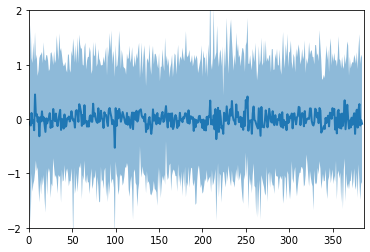

In [24]:
x = range(1,385)
mean = embedding_train_X.describe().iloc[1,:].tolist()
min = embedding_train_X.describe().iloc[3,:].tolist()
max = embedding_train_X.describe().iloc[7,:].tolist()
fig, ax = plt.subplots()
ax.fill_between(x, min, max, alpha=.5, linewidth=0)
ax.plot(x, mean, linewidth=2, )
ax.set(xlim=(0, 386),
       ylim=(-2, 2), yticks=np.arange(-2, 3))
plt.show()
fig.savefig("embedding.jpg",dpi=300)

In [22]:
y_pred = support_vector_machine(embedding_train_X, train_y,embedding_test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score  support
negative       0.654229  0.638350  0.646192   412.00
positive       0.625628  0.641753  0.633588   388.00
accuracy       0.640000  0.640000  0.640000     0.64
macro avg      0.639928  0.640051  0.639890   800.00
weighted avg   0.640358  0.640000  0.640079   800.00
accuracy_score: 0.64


,precision,recall,f1-score,support
negative,0.654229,0.638350,0.646192,412.00
positive,0.625628,0.641753,0.633588,388.00
accuracy,0.640000,0.640000,0.640000,0.64
macro avg,0.639928,0.640051,0.639890,800.00
weighted avg,0.640358,0.640000,0.640079,800.00


In [33]:
# baseline
baseline_pred = zero_rule_algorithm_classification(embedding_train_y.tolist(), embedding_test_y.tolist())
supervised_learning_evaluate(pred_transfer(baseline_pred), pred_transfer(test_y))

              precision  recall  f1-score  support
negative       0.000000   0.000  0.000000  412.000
positive       0.485000   1.000  0.653199  388.000
accuracy       0.485000   0.485  0.485000    0.485
macro avg      0.242500   0.500  0.326599  800.000
weighted avg   0.235225   0.485  0.316801  800.000
accuracy_score: 0.485


D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
negative,0.000000,0.000,0.000000,412.000
positive,0.485000,1.000,0.653199,388.000
accuracy,0.485000,0.485,0.485000,0.485
macro avg,0.242500,0.500,0.326599,800.000
weighted avg,0.235225,0.485,0.316801,800.000


In [91]:
# logistic regression
y_pred = logistic(embedding_train_X, embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, pred_transfer(test_y))

              precision    recall  f1-score   support
negative       0.674020  0.667476  0.670732  412.0000
positive       0.650510  0.657216  0.653846  388.0000
accuracy       0.662500  0.662500  0.662500    0.6625
macro avg      0.662265  0.662346  0.662289  800.0000
weighted avg   0.662618  0.662500  0.662542  800.0000
accuracy_score: 0.6625


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,precision,recall,f1-score,support
negative,0.674020,0.667476,0.670732,412.0000
positive,0.650510,0.657216,0.653846,388.0000
accuracy,0.662500,0.662500,0.662500,0.6625
macro avg,0.662265,0.662346,0.662289,800.0000
weighted avg,0.662618,0.662500,0.662542,800.0000


In [81]:
# Multinomial Naïve Bayes
y_pred = mnb_train_predict(embedding_train_X, embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, test_set['Sentiment'])

ValueError: Negative values in data passed to MultinomialNB (input X)

In [82]:
# Bernoulli Naïve Bayes
y_pred = bnb_train_predict(embedding_train_X, embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, test_set['Sentiment'])

              precision    recall  f1-score    support
negative       0.646570  0.754854  0.696529  412.00000
positive       0.683386  0.561856  0.616690  388.00000
accuracy       0.661250  0.661250  0.661250    0.66125
macro avg      0.664978  0.658355  0.656609  800.00000
weighted avg   0.664425  0.661250  0.657807  800.00000
accuracy_score: 0.66125


,precision,recall,f1-score,support
negative,0.646570,0.754854,0.696529,412.00000
positive,0.683386,0.561856,0.616690,388.00000
accuracy,0.661250,0.661250,0.661250,0.66125
macro avg,0.664978,0.658355,0.656609,800.00000
weighted avg,0.664425,0.661250,0.657807,800.00000


In [21]:
# AdaBoost
y_pred = ada_boost(embedding_train_X,embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, test_set['Sentiment'])

              precision    recall  f1-score  support
negative       0.698864  0.597087  0.643979   412.00
positive       0.629464  0.726804  0.674641   388.00
accuracy       0.660000  0.660000  0.660000     0.66
macro avg      0.664164  0.661946  0.659310   800.00
weighted avg   0.665205  0.660000  0.658850   800.00
accuracy_score: 0.66


,precision,recall,f1-score,support
negative,0.698864,0.597087,0.643979,412.00
positive,0.629464,0.726804,0.674641,388.00
accuracy,0.660000,0.660000,0.660000,0.66
macro avg,0.664164,0.661946,0.659310,800.00
weighted avg,0.665205,0.660000,0.658850,800.00


In [27]:
# GradientBoosting
y_pred = grad_boost(embedding_train_X,embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, test_set['Sentiment'])

              precision    recall  f1-score    support
negative       0.638404  0.621359  0.629766  412.00000
positive       0.609023  0.626289  0.617535  388.00000
accuracy       0.623750  0.623750  0.623750    0.62375
macro avg      0.623713  0.623824  0.623651  800.00000
weighted avg   0.624154  0.623750  0.623834  800.00000
accuracy_score: 0.62375


,precision,recall,f1-score,support
negative,0.638404,0.621359,0.629766,412.00000
positive,0.609023,0.626289,0.617535,388.00000
accuracy,0.623750,0.623750,0.623750,0.62375
macro avg,0.623713,0.623824,0.623651,800.00000
weighted avg,0.624154,0.623750,0.623834,800.00000


In [47]:
# Random Forest
y_pred =  random_forest(tfidf_list_to_df(embedding_dev['TFIDF'], range(384)),embedding_dev['label'], tfidf_list_to_df(embedding_test['TFIDF'], range(384)))
test_data_output([y_pred], ['RandomForestClassifier_embedding_pred.csv'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


building tree 4 of 100
building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


building tree 6 of 100
building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s


building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [93]:
# Random Forest
y_pred =  random_forest(embedding_train_X,embedding_train_y, embedding_test_X)
supervised_learning_evaluate(y_pred, test_set['Sentiment'])

              precision    recall  f1-score  support
negative       0.690955  0.667476  0.679012  412.000
positive       0.659204  0.682990  0.670886  388.000
accuracy       0.675000  0.675000  0.675000    0.675
macro avg      0.675079  0.675233  0.674949  800.000
weighted avg   0.675556  0.675000  0.675071  800.000
accuracy_score: 0.675


,precision,recall,f1-score,support
negative,0.690955,0.667476,0.679012,412.000
positive,0.659204,0.682990,0.670886,388.000
accuracy,0.675000,0.675000,0.675000,0.675
macro avg,0.675079,0.675233,0.674949,800.000
weighted avg,0.675556,0.675000,0.675071,800.000


In [95]:
self_training_pred = self_training(embedding_train_X,embedding_train_y, embedding_test_X)
supervised_learning_evaluate(self_training_pred, test_set['Sentiment'])

              precision    recall  f1-score  support
negative       0.537736  0.415049  0.468493  412.000
positive       0.500000  0.621134  0.554023  388.000
accuracy       0.515000  0.515000  0.515000    0.515
macro avg      0.518868  0.518091  0.511258  800.000
weighted avg   0.519434  0.515000  0.509975  800.000
accuracy_score: 0.515


C:\Users\Simin Zuo\AppData\Local\Temp/ipykernel_11448/2986017429.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[random_unlabeled_points] = -1
D:\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,precision,recall,f1-score,support
negative,0.537736,0.415049,0.468493,412.000
positive,0.500000,0.621134,0.554023,388.000
accuracy,0.515000,0.515000,0.515000,0.515
macro avg,0.518868,0.518091,0.511258,800.000
weighted avg,0.519434,0.515000,0.509975,800.000


In [97]:
Label_Spreading_pred = label_spreading(embedding_train_X,embedding_train_y, embedding_test_X)
supervised_learning_evaluate(Label_Spreading_pred, test_set['Sentiment'])

              precision    recall  f1-score  support
negative       0.517588  1.000000  0.682119   412.00
positive       1.000000  0.010309  0.020408   388.00
accuracy       0.520000  0.520000  0.520000     0.52
macro avg      0.758794  0.505155  0.351264   800.00
weighted avg   0.751558  0.520000  0.361189   800.00
accuracy_score: 0.52


D:\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:205: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


,precision,recall,f1-score,support
negative,0.517588,1.000000,0.682119,412.00
positive,1.000000,0.010309,0.020408,388.00
accuracy,0.520000,0.520000,0.520000,0.52
macro avg,0.758794,0.505155,0.351264,800.00
weighted avg,0.751558,0.520000,0.361189,800.00


In [96]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(max_features='auto', verbose=10).fit(embedding_train_X,embedding_train_y)
y_pred = pred_transfer(clf.predict(embedding_test_X))
supervised_learning_evaluate(y_pred, test_set['Sentiment'])
print(metrics.accuracy_score(y_pred, test_set['Sentiment']))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [41]:
# kmeans
pred = k_means(embedding_train_X, embedding_test_X)
unsupervised_learning_evaluate(pred, test_set['Sentiment'])

Purity: 0.61
Entropy: 0.6109


D:\anaconda3\lib\site-packages\scipy\stats\_entropy.py:78: RuntimeWarning: divide by zero encountered in true_divide
  qk = 1.0*qk / np.sum(qk, axis=axis, keepdims=True)
D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


0


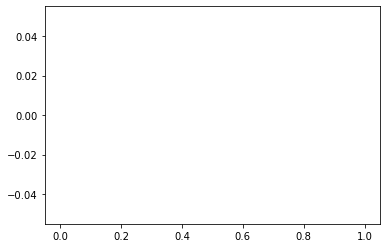

In [102]:
JS = []
selected_instances = []
for i in range(len(embedding_dev['TFIDF'])):
    instance = embedding_dev.iloc[i,0]
    rest = embedding_dev.iloc[i,:]
    min_js = 1
    for item in embedding_test['TFIDF']:
        js = JS_divergence(item, instance)
        if js < min_js:
            min_js = js
    if min_js <= 0.3:
        JS.append(min_js)
        selected_instances.append(rest)
selected_data = pd.DataFrame(selected_instances)
plt.hist(JS)
print(len(JS))

In [5]:
raw = pd.read_csv('raw.csv')
raw_original = raw['Accuracy score']
raw_kbest = raw['K-best ']
raw_Fpr = raw['Fpr']
tfidf = pd.read_csv('tfidf.csv')
tfidf_original = tfidf['Accuracy score']
tfidf_kbest = tfidf['K-best ']
tfidf_Fpr = tfidf['Fpr']

import scipy.stats
test_record = {}
temp = {}
t, pval = scipy.stats.ttest_rel(raw_original, raw_kbest, alternative='less')
temp['raw'] = (t, pval)
t, pval = scipy.stats.ttest_rel(tfidf_original, tfidf_kbest, alternative='less')
temp['tfidf'] = (t, pval)
test_record['Kbest'] = temp
temp = {}
t, pval = scipy.stats.ttest_rel(raw_original, raw_Fpr, alternative='less')
temp['raw'] = (t, pval)
t, pval = scipy.stats.ttest_rel(tfidf_original, tfidf_Fpr, alternative='less')
temp['tfidf'] = (t, pval)
test_record['Fpr'] = temp

test_record = pd.DataFrame(test_record)
print(test_record)
test_record.to_csv('t-test.csv')

                                            Kbest  \
raw     (-1.905986326407495, 0.05264612479218673)   
tfidf  (-1.9411442453304726, 0.04668876728093503)   

                                               Fpr  
raw     (-1.6493556505433444, 0.07508449024650454)  
tfidf  (-1.9561403398916255, 0.045668806838017516)  
